# Using Machine Learning to Combat Financial Fraud

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Set additional options
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

### 1. Load Data

Data was found on kaggle ....

In [3]:
raw_data = pd.read_csv(r"C:\Users\e014694\OneDrive - Telstra\Documents\Git\Fraudulent_payments\Data\Base.csv")

raw_data.head()

raw_dataa = raw_data

In [4]:
fraud_counts = pd.DataFrame(raw_data['fraud_bool'].value_counts()).reset_index()
fraud_counts

,fraud_bool,count
0,0,988971
1,1,11029


As with most fraud data sets, it can be seen the data is heavily 'imbalanced'. Where a tiny proportion of the data is actually positive and and even distribution is not seen. This will be addressed later.

Visualising the size of the imbalance...

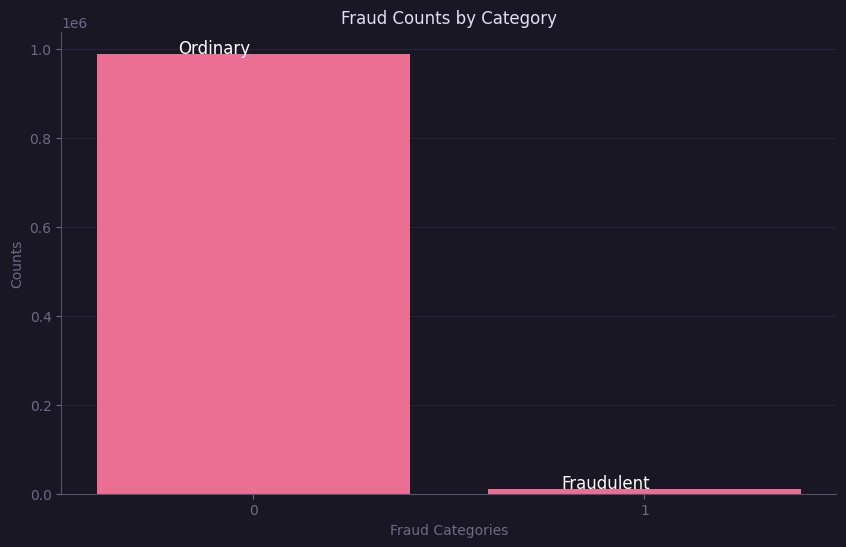

In [5]:
plt.style.use('rose-pine')

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(fraud_counts['fraud_bool'], fraud_counts['count'])
plt.xlabel('Fraud Categories')
plt.ylabel('Counts')
plt.title('Fraud Counts by Category')

labels = ['Ordinary', 'Fraudulent']

# Add custom labels to the bars
for bar, label in zip(bars, labels):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, label, ha='center', color='white', fontsize=12)

# Customize the x-axis tick labels
plt.xticks([0, 1], ['0', '1'])

# Show the chart
plt.show()

---

### 2. Data Preparation

First we need to investigate the data to observe the suitablitlty for modelling. The aim is to prepare the data to aide the model

[improve...]

In [6]:
raw_data.head(5).T

,0,1,2,3,4
fraud_bool,1,1,1,1,1
income,0.90,0.90,0.90,0.90,0.90
name_email_similarity,0.17,0.30,0.04,0.16,0.60
prev_address_months_count,-1,-1,-1,-1,-1
current_address_months_count,88,144,132,22,218
customer_age,50,50,40,50,50
days_since_request,0.02,0.01,3.11,0.02,0.00
intended_balcon_amount,-1.33,-0.82,-0.76,-1.21,-0.77
payment_type,AA,AB,AC,AB,AB
zip_count_4w,769,366,870,810,890


In [7]:
raw_data.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
mean,0.01,0.56,0.49,16.72,86.59,33.69,1.03,8.66,1572.69,5665.30,4769.78,4856.32,184.36,9.50,130.99,0.53,0.42,0.89,10.84,0.22,515.85,0.03,7.54,0.58,1.02,0.00,3.29
std,0.10,0.29,0.29,44.05,88.41,12.03,5.38,20.24,1005.37,3009.38,1479.21,919.84,459.63,5.03,69.68,0.50,0.49,0.31,12.12,0.42,487.56,0.16,8.03,0.49,0.18,0.00,2.21
min,0.00,0.10,0.00,-1.00,-1.00,10.00,0.00,-15.53,1.00,-170.60,1300.31,2825.75,0.00,0.00,-170.00,0.00,0.00,0.00,-1.00,0.00,190.00,0.00,-1.00,0.00,-1.00,0.00,0.00
25%,0.00,0.30,0.23,-1.00,19.00,20.00,0.01,-1.18,894.00,3436.37,3593.18,4268.37,1.00,6.00,83.00,0.00,0.00,1.00,-1.00,0.00,200.00,0.00,3.10,0.00,1.00,0.00,1.00
50%,0.00,0.60,0.49,-1.00,52.00,30.00,0.02,-0.83,1263.00,5319.77,4749.92,4913.44,9.00,9.00,122.00,1.00,0.00,1.00,5.00,0.00,200.00,0.00,5.11,1.00,1.00,0.00,3.00
75%,0.00,0.80,0.76,12.00,130.00,40.00,0.03,4.98,1944.00,7680.72,5752.57,5488.08,25.00,13.00,178.00,1.00,1.00,1.00,25.00,0.00,500.00,0.00,8.87,1.00,1.00,0.00,5.00
max,1.00,0.90,1.00,383.00,428.00,90.00,78.46,112.96,6700.00,16715.57,9506.90,6994.76,2385.00,39.00,389.00,1.00,1.00,1.00,32.00,1.00,2100.00,1.00,85.90,1.00,2.00,0.00,7.00


The data can be broken into 4 groups:

* Target Column - This is the column indicating fraud or not
* Numeric Columns - These columns hold continous numeric data, like Age, Income or Number of Months.
* Numeric (Binary) - This is a subset of the Numeric columns that are just filled with 1s & 0s indicating the answer to a Yes or No questions. Such as, is the phone number valid?
* Non Numeric - These are categorical columns where the data response is not a number. Such as what is the Operating system? Windows, OS, Linux.

Numeric columns require a scaling to be applied to them to ensure the values are standardised. Large variations in the data can impair model performance. For poorly distibuted data a logarithmic function can be applied to improve the data distribution. Sci-Kit Learn's MinMaxScaler is used here to format the numeric data here between 0 & 1. Other variations can scale data between -1 & 1.

Numeric binary doesn't need any pre-processing and can remain.

Non-Numeric, or categorical, require One-hot encoding. This is a technique used in data preprocessing and feature engineering, primarily in the context of machine learning and data analysis. It's employed to represent categorical variables as binary vectors (0s and 1s). Each category or label within a categorical variable is transformed into a binary feature, where each feature corresponds to one category and is either "on" (1) or "off" (0) based on whether the original data point falls into that category.

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Split the DataFrame into the target column, numeric, and non-numeric columns
target_column = raw_data['fraud_bool']
numeric_columns = raw_data.drop(columns = 'fraud_bool').select_dtypes(include=['int64', 'float64'])
non_numeric_columns = raw_data.select_dtypes(exclude=['int64', 'float64'])

# Identify and filter out columns with just 0s and 1s
non_std_columns = []
for column in numeric_columns.columns:
    unique_values = numeric_columns[column].unique()
    if len(unique_values) > 2 or not all(val in {0, 1} for val in unique_values):
        non_std_columns.append(column)

#bool columns
binary_columns = numeric_columns.drop(columns = non_std_columns)

# numeric Columns
numeric_columns = numeric_columns.drop(columns = binary_columns)


# Apply one-hot encoding to non-numeric columns
non_numeric_encoded = pd.get_dummies(non_numeric_columns)

# Initialize the MinMaxScaler with a specific range (e.g., 0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
numeric_scaled = pd.DataFrame(scaler.fit_transform(numeric_columns), columns=numeric_columns.columns)

# Concatenate the target column, non-numeric columns, and scaled numeric columns
processed_data = pd.concat([
                            target_column,
                            non_numeric_encoded,
                            binary_columns, 
                            numeric_scaled], axis=1)

# Now, processed_data contains the target column, non-numeric columns, and scaled numeric columns (excluding 0s and 1s columns).
processed_data

,fraud_bool,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,device_fraud_count,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month
0,1,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,0,1,0,0,0,0,0,1.00,0.17,0.00,0.21,0.50,0.00,0.11,0.11,0.64,0.22,0.25,0.00,0.15,0.64,0.76,0.16,0.06,0.67,1.00
1,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,1,0,0,0,0,0,0,1.00,0.30,0.00,0.34,0.50,0.00,0.11,0.05,0.04,0.17,0.07,0.30,0.08,0.77,0.48,0.69,0.38,0.67,1.00
2,1,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,1,0,1,0,0,0,0,1.00,0.04,0.00,0.31,0.38,0.04,0.11,0.13,0.25,0.19,0.08,0.00,0.36,0.62,0.00,0.01,0.07,0.67,1.00
3,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,1,0,1,1,0,0,0,1.00,0.16,0.00,0.05,0.50,0.00,0.11,0.12,0.21,0.34,0.05,0.81,0.15,0.50,0.97,0.01,0.04,0.67,1.00
4,1,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,1,1,0,0,0,1,0,1.00,0.60,0.00,0.51,0.50,0.00,0.11,0.13,0.31,0.17,0.06,0.83,0.05,0.83,0.97,0.69,0.05,0.67,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,1,1,1,0,0,1,0,0.63,0.19,0.00,0.24,0.38,0.00,0.11,0.12,0.48,0.86,0.51,0.00,0.21,0.44,0.79,0.01,0.11,0.67,0.57
999996,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,1,1,1,0,0,0,0,0.88,0.32,0.39,0.02,0.50,0.02,0.11,0.49,0.33,0.45,0.53,0.00,0.05,0.58,0.00,0.01,0.11,0.67,0.57
999997,0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,0,0,1,0,0,0,0,0.88,0.88,0.00,0.07,0.12,0.00,0.39,0.23,0.49,0.53,0.37,0.85,0.15,0.42,0.36,0.01,0.11,0.67,0.57
999998,0,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,0,1,0,0,0,1,0,1.00,0.76,0.00,0.44,0.12,0.00,0.86,0.21,0.49,0.33,0.38,0.70,0.15,0.60,0.88,0.16,0.06,0.67,0.57


The impact can be seen below, .....

In [9]:
processed_data.describe(include = 'all')

,fraud_bool,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,device_fraud_count,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month
count,1000000.00,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
unique,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,741751,629446,747929,881163,999711,730252,861712,962242,973478,977307,955966,999547,830325,739035,627857,973839,830865,998331,999748,992952,992952,667288,946174,657272,736494,992772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53,0.42,0.89,0.22,0.03,0.58,0.00,0.58,0.49,0.05,0.20,0.30,0.01,0.19,0.23,0.35,0.42,0.49,0.08,0.24,0.54,0.36,0.17,0.10,0.67,0.47
std,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.49,0.31,0.42,0.16,0.49,0.00,0.36,0.29,0.11,0.21,0.15,0.07,0.16,0.15,0.18,0.18,0.22,0.19,0.13,0.12,0.37,0.26,0.09,0.06,0.32
min,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.25,0.23,0.00,0.05,0.12,0.00,0.11,0.13,0.21,0.28,0.35,0.00,0.15,0.45,0.00,0.01,0.05,0.67,0.14
50%,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.63,0.49,0.00,0.12,0.25,0.00,0.11,0.19,0.33,0.42,0.50,0.00,0.23,0.52,0.18,0.01,0.07,0.67,0.43
75%,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.88,0.76,0.03,0.31,0.38,0.00,0.16,0.29,0.46,0.54,0.64,0.01,0.33,0.62,0.79,0.16,0.11,0.67,0.71


### 2.2 Data Skewness

Skewwnes: Skewness is the degree of asymmetry observed in a distribution. Distributions can exhibit right (positive) skewness or left (negative) skewness to varying degrees. A normal distribution (bell curve) exhibits zero skewness.

Skewed data can have an adverse impact when modelling as the data points are not distruted through the range in an even manor. [improve]

# MAY NEED TO APPLY SKEW BEFORE SCALE

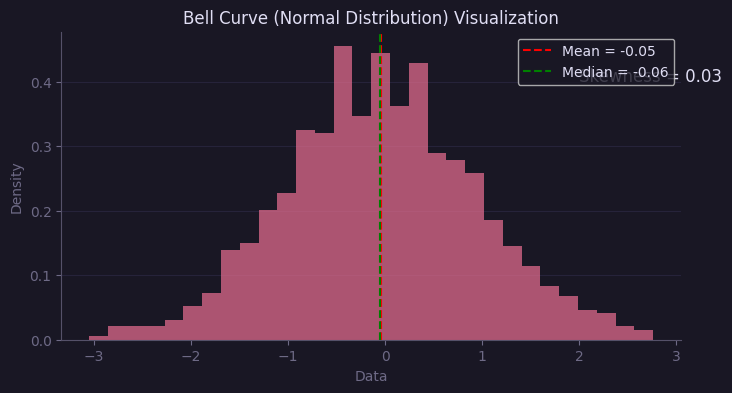

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a sample dataset with a bell curve (normal distribution)
np.random.seed(0)
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
data = np.random.normal(mean, std_dev, size=1000)  # Example dataset with a bell curve

# Create a DataFrame
df = pd.DataFrame({'Data': data})

# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(df['Data'], bins=30, density=True, alpha=0.7)
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = df['Data'].skew()
plt.axvline(x=df['Data'].mean(), color='red', linestyle='--', label=f'Mean = {df["Data"].mean():.2f}')
plt.axvline(x=df['Data'].median(), color='green', linestyle='--', label=f'Median = {df["Data"].median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()


Above is an example of what a normally distributed data set could look like. Where the mean and median are in the middle of the distribution.

Below is one column that displays highly skewed data and how a log transformation can aid to rectify this.

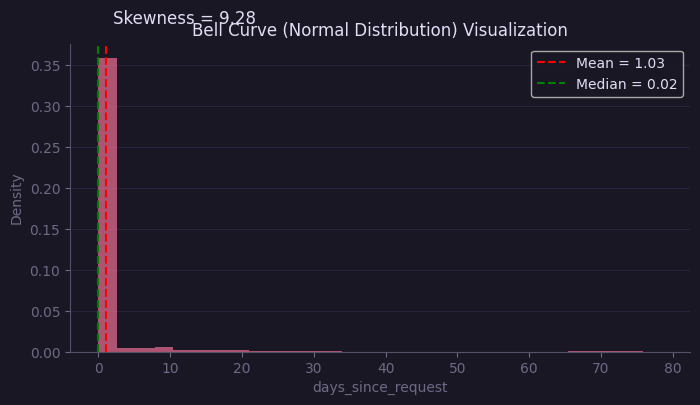

In [11]:
# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(raw_data['days_since_request'], bins=30, density=True, alpha=0.7)
plt.xlabel('days_since_request')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = raw_data['days_since_request'].skew()
plt.axvline(x=raw_data['days_since_request'].mean(), color='red', linestyle='--', label=f'Mean = {raw_data["days_since_request"].mean():.2f}')
plt.axvline(x=raw_data['days_since_request'].median(), color='green', linestyle='--', label=f'Median = {raw_data["days_since_request"].median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()

Visualising the 'days_since_request' field shows how non-normal distribution may look. To remedy this a log function can be used to improve the distrubtion for our purposes.

In [12]:
test_field = np.log10(raw_data['days_since_request'])

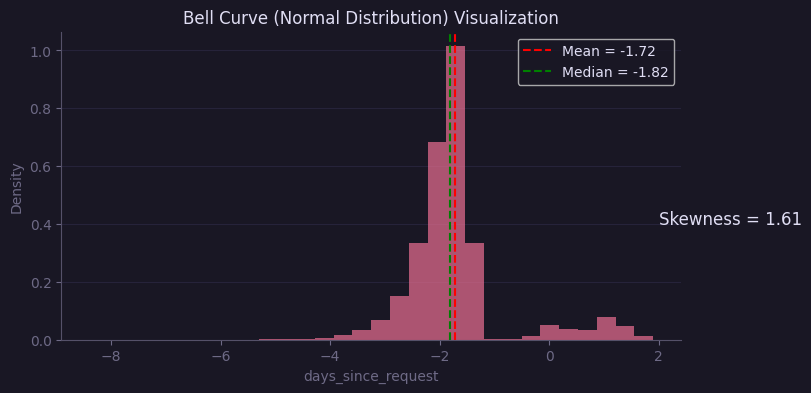

In [13]:
# Create a histogram to visualize skewness
plt.figure(figsize=(8, 4))
plt.hist(test_field, bins=30, density=True, alpha=0.7)
plt.xlabel('days_since_request')
plt.ylabel('Density')
plt.title('Bell Curve (Normal Distribution) Visualization')

# Calculate skewness
skewness = test_field.skew()
plt.axvline(x=test_field.mean(), color='red', linestyle='--', label=f'Mean = {test_field.mean():.2f}')
plt.axvline(x=test_field.median(), color='green', linestyle='--', label=f'Median = {test_field.median():.2f}')
plt.legend()
plt.text(2, 0.4, f'Skewness = {skewness:.2f}', fontsize=12)

plt.show()

As can be seen in the graph, applying a log10 function to the field has improved the skew of the data. Reducing the skew score from 9.28 to 1.61, roughly a 9x improvement in skew. This will support the model in assessing the impact the variation of these fields have on the output.

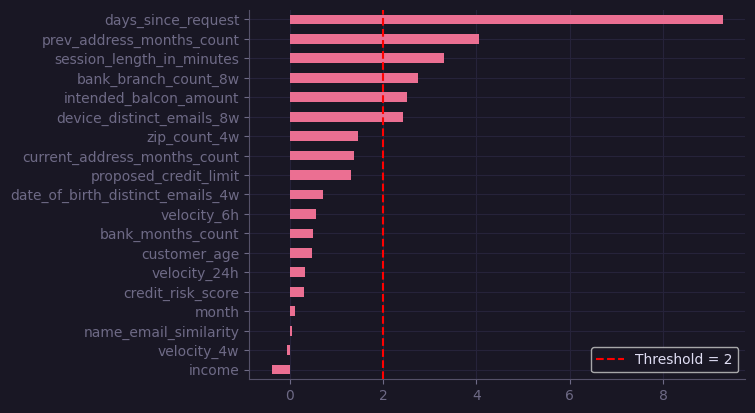

In [14]:
processed_data[numeric_columns.columns].skew(numeric_only=True).sort_values().plot(kind = 'barh')

plt.axvline(x=2, color='red', linestyle='--', label='Threshold = 2')
plt.legend()

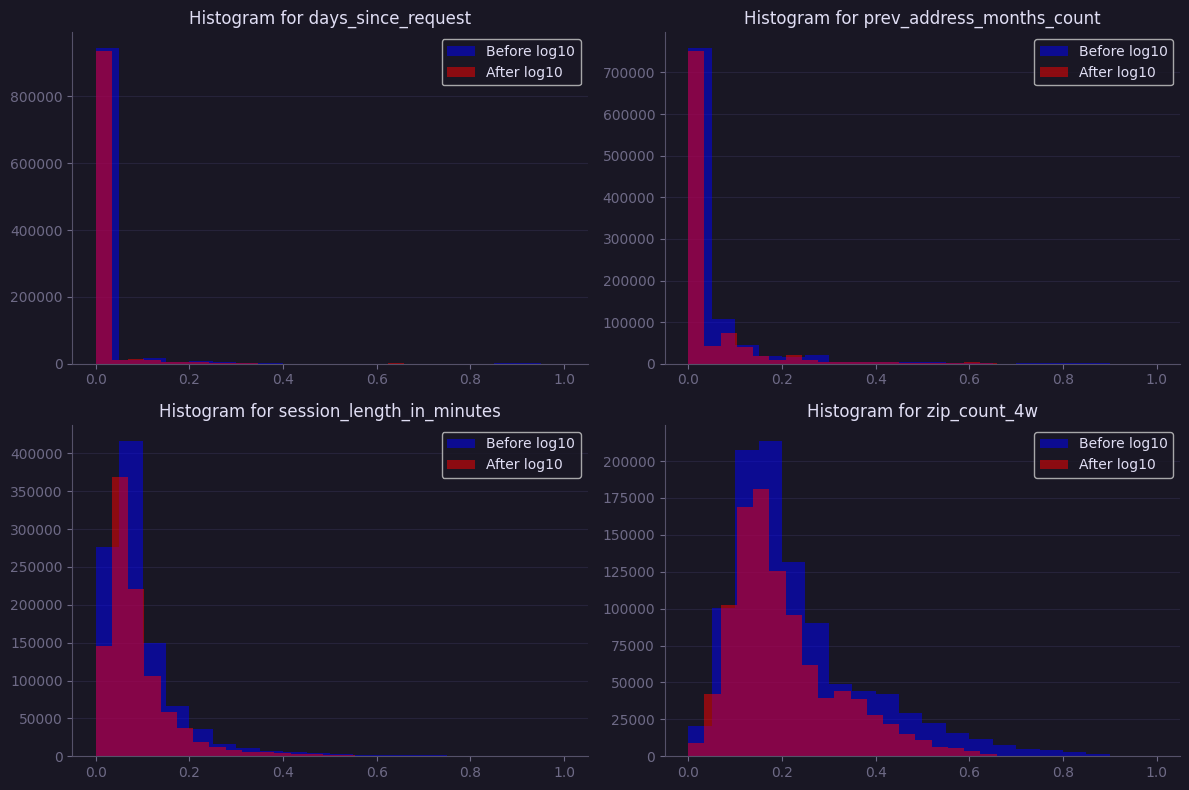

In [15]:
# List of columns to apply log10 to
columns_to_log = ['days_since_request', 'prev_address_months_count', 'session_length_in_minutes', 'zip_count_4w']

# Create a figure with subplots for each column
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, column in enumerate(columns_to_log):
    row = i // 2
    col = i % 2

    # Plot the histogram before applying log10
    axes[row, col].hist(processed_data[column], bins=20, color='blue', alpha=0.5, label='Before log10')
    
    # Plot the histogram after applying log10
    axes[row, col].hist(np.log1p(processed_data[column]), bins=20, color='red', alpha=0.5, label='After log10')
    
    axes[row, col].set_title(f'Histogram for {column}')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

Only makes a small improvement due to the very large number of '0' values present. Scaling before log function could be muting impact.

In [16]:
# Apply a log transformation to the features that were over the threshold
processed_data['log_days_since_request'] = np.log1p(processed_data['days_since_request'])
processed_data['log_prev_address_months_count'] = np.log1p(processed_data['prev_address_months_count'])
processed_data['log_session_length_in_minutes'] = np.log1p(processed_data['session_length_in_minutes'])


#cleaning_data['bank_branch_count_8w'] = np.log10(cleaning_data['bank_branch_count_8w'])   this gives inf vaules, either ignore or find the best way to sub

In [17]:
processed_data.drop(columns = ['days_since_request','prev_address_months_count','session_length_in_minutes'], inplace = True)

In [18]:
# Find NaN values in the DataFrame
nan_values = processed_data.isna()

# Count NaN values in each column
nan_count = nan_values.sum()

# Locate rows with NaN values
nan_locations = processed_data[nan_values.any(axis=1)]

In [19]:
nan_count.sort_values(ascending=False).head(3)

fraud_bool            0
email_is_free         0
phone_mobile_valid    0
dtype: int64

In [20]:
# Find NaN values in the DataFrame
inf_values = np.isinf(processed_data)

# Count NaN values in each column
inf_count = inf_values.sum()

# Locate rows with NaN values
inf_locations = processed_data[inf_values.any(axis=1)]

In [21]:
inf_count.sort_values(ascending=False).head(3)

fraud_bool            0
email_is_free         0
phone_mobile_valid    0
dtype: int64

---

## 4. Sampling correction

Seen below, the number of fraud instances compared to non-fraud is extremely small. This is common among many different Machine Learning problems including Fraud Detection, Loan Defaulting Predictions and Insurance Claim Predictions. 

This in called Imbalanced Classification, where the dataset (and expected outcomes) are vastly disproportionate. Regular Machine Learning models struggle with this as they are designed for datasets with more balanced outcomes.

There are a number of ways to combat this:
- Gathering more data
- Differing sampling techniques
- Changing models
- Generating synthetic data

For this problem synthetic data will be generated to provide a data set that has more fraud outcomes. A risk of this is the assumption on the generated data posseing the same trends and nuances as the original data. This can be addressed in the evaluation of performance.

### Example: Customer Age

Seen below, the vast difference in the amount of instances in non-fraud to fraud. This makes is extremely hard for the algorithm to make correct predictions.

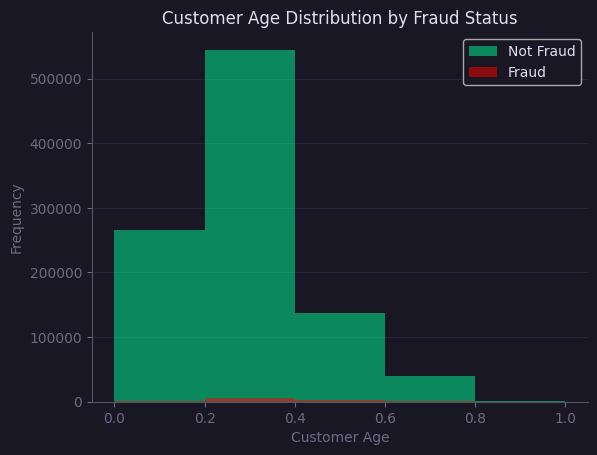

In [22]:
# Create a histogram plot
plt.hist([age for age, is_fraud in zip(processed_data['customer_age'], processed_data['fraud_bool']) if is_fraud == 0], 
         bins=5, alpha=0.5, label='Not Fraud', color='mediumspringgreen')
plt.hist([age for age, is_fraud in zip(processed_data['customer_age'], processed_data['fraud_bool']) if is_fraud == 1], 
         bins=5, alpha=0.5, label='Fraud', color='red')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution by Fraud Status')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Synthetic Minority Over-sampling Technique

As its name suggests, SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

# ADD VISUAL

In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.8, random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(processed_data.drop(columns='fraud_bool'), processed_data['fraud_bool'])

print('Distribution of label values before applying SMOTE:\n',pd.Series(processed_data['fraud_bool']).value_counts())
print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

Distribution of label values before applying SMOTE:
 fraud_bool
0    988971
1     11029
Name: count, dtype: int64
Distribution of label values after applying SMOTE:
 fraud_bool
0    988971
1    791176
Name: count, dtype: int64


After applying SMOTE the dataset now has a 50-50 split of fraud and non-fraud

In [24]:
dataset_SMOTE = X_train_smote
dataset_SMOTE['fraud_bool'] = y_train_smote

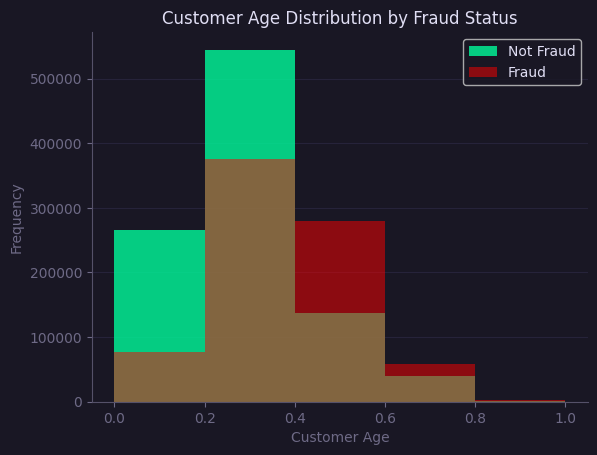

In [25]:
# Create a histogram plot
plt.hist([age for age, is_fraud in zip(dataset_SMOTE['customer_age'], dataset_SMOTE['fraud_bool']) if is_fraud == 0], 
         bins=5, alpha=0.8, label='Not Fraud', color='mediumspringgreen')
plt.hist([age for age, is_fraud in zip(dataset_SMOTE['customer_age'], dataset_SMOTE['fraud_bool']) if is_fraud == 1], 
         bins=5, alpha=0.5, label='Fraud', color='red')

# Add labels and title
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.title('Customer Age Distribution by Fraud Status')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The histogram shows a significant increase in the fraud category. This is a result of the syntetic data that has been create using SMOTE.

In [26]:
smote_counts = pd.DataFrame(dataset_SMOTE['fraud_bool'].value_counts()).reset_index()

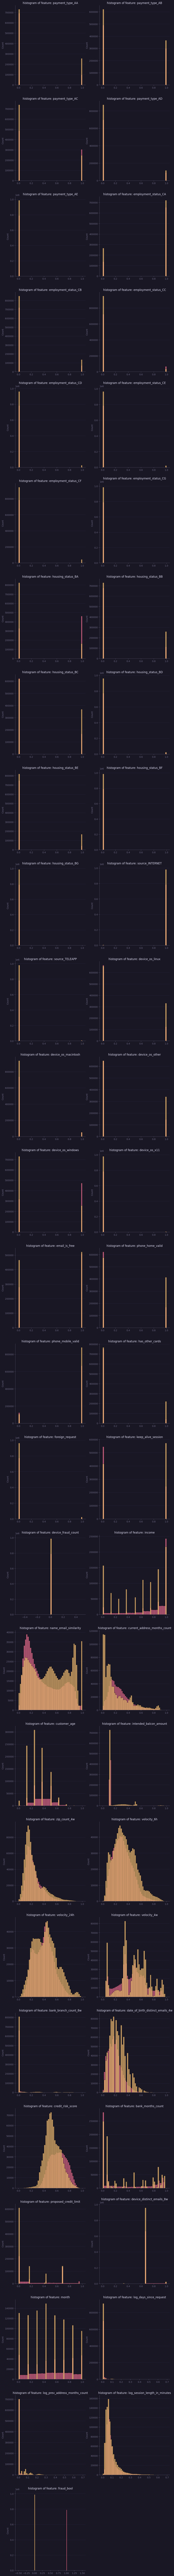

In [27]:
from matplotlib import gridspec
import seaborn as sns
# distribution of anomalous features


plt.figure(figsize=(12,52*4))
gs = gridspec.GridSpec(28, 2)
for i, c in enumerate(dataset_SMOTE):
    ax = plt.subplot(gs[i])
    sns.histplot(dataset_SMOTE[c][dataset_SMOTE.fraud_bool == 1], bins=50)
    sns.histplot(dataset_SMOTE[c][dataset_SMOTE.fraud_bool == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(c))
plt.show()

may need to change some of the smote generated data for where data is bucketed.

-----

## 5 Feature Selection

Having cleaned, adjusted and scaled all of the features within the dataset it is now time to see which of these contribute the most to determining is a transaction is fraudulent or not.

Firstly the correlation is assessed for the greatest correlation with fraud.When features within a dataset correlate too much, often indicating some causal-relationship, it can negaitivley impact the model and lead to overfitting of the data. As such it's necessary to check for these instances and remove additional features that may be redundant.

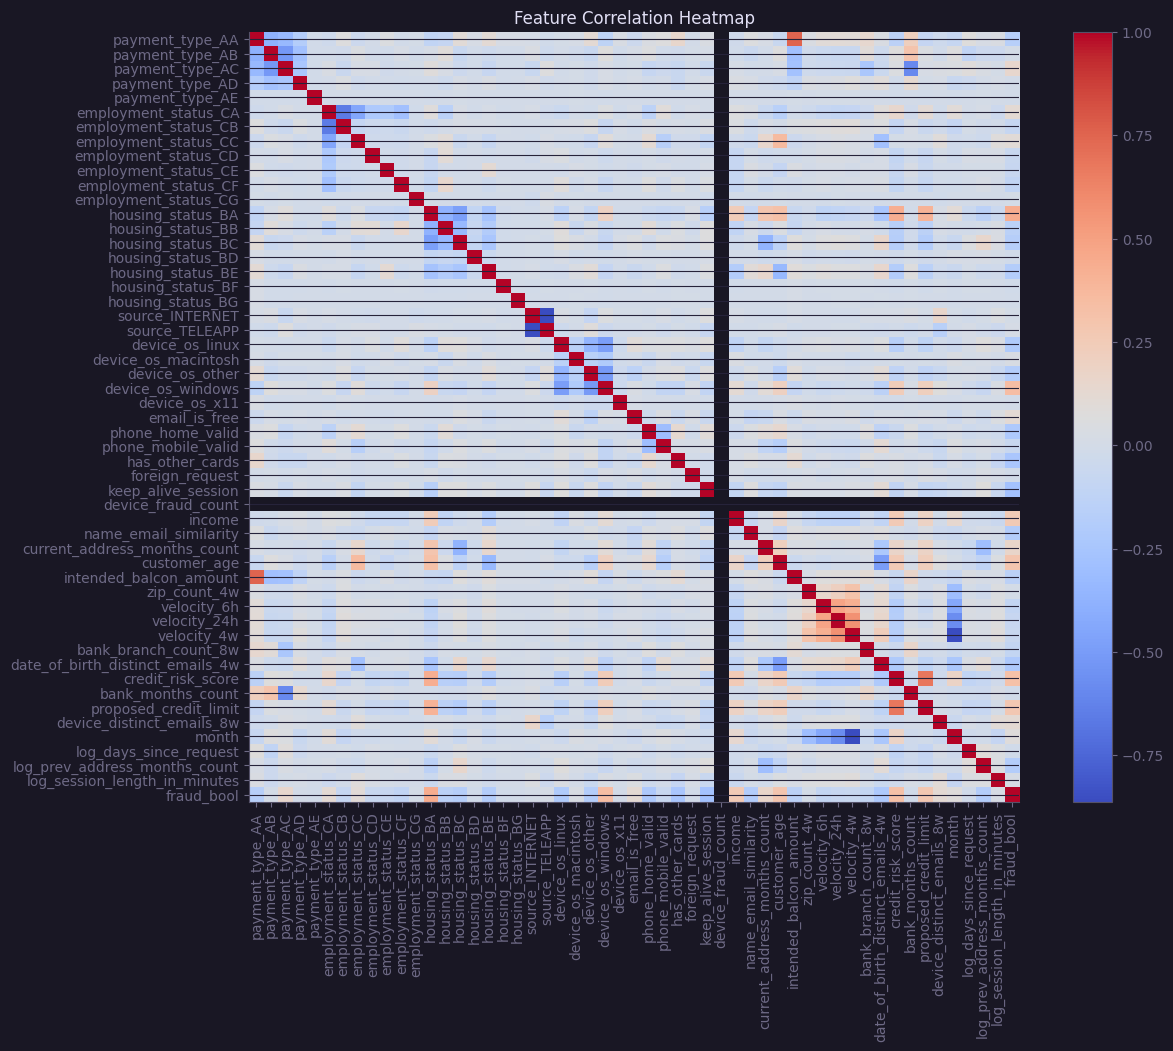

In [28]:
# Calculate the correlation matrix
correlation_matrix = dataset_SMOTE.corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(14, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns),), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns),), correlation_matrix.columns)
plt.title('Feature Correlation Heatmap')
plt.show()


There are varying levels of correlation in the dataset. To quickly identify which are too heavily correlated, the matrix can be flattend to leave feature pairs and correlation value and sorted by value

In [29]:
# Reference column adding to enable the flattening
correlation_matrix['ref'] = correlation_matrix.index

In [30]:
# melt function flattens and values of 1 (the same variable correlation) excluded and sorted
flat_correlation_matrix = correlation_matrix.melt(id_vars='ref')
flat_correlation_matrix[
    (flat_correlation_matrix['value'] != 1) &
    (flat_correlation_matrix['value'] > 0.7)]

,ref,variable,value
37,intended_balcon_amount,payment_type_AA,0.75
1961,payment_type_AA,intended_balcon_amount,0.75


This leaves just one correlation pair of payment_type_AA and intended_balcon_amount. Inspecting the data, this correlation seems to come from when payment_type_AA is 0 the intended_balcon_amount is negative and vis versa.

To redunce the dependancy and limit overfitting, payment_type_AA is removed.

In [31]:
dataset_SMOTE.drop(columns = 'payment_type_AA', inplace= True)

### 5.1 Feature selection

Using every feature within a model leads to an overfitted and inflexible model. It is therefor advantageous to identify the most impactful feature that contribute to predicting fraud, and remove the least useful ones.

#### Mutual Information Feature Selection Method
Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection.

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(dataset_SMOTE.drop('fraud_bool', axis=1), dataset_SMOTE['fraud_bool'], test_size=0.2, random_state=0)

In [34]:
X_train.head(5)

,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,keep_alive_session,device_fraud_count,income,name_email_similarity,current_address_months_count,customer_age,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,device_distinct_emails_8w,month,log_days_since_request,log_prev_address_months_count,log_session_length_in_minutes
1045218,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,1,0,1,0,0,1,0,0.38,0.08,0.13,0.38,0.11,0.41,0.33,0.33,0.48,0.00,0.18,0.46,0.00,0.01,0.67,0.42,0.00,0.00,0.03
315112,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,1,0,1,0,0,0,0,0.38,1.00,0.45,0.00,0.29,0.16,0.23,0.39,0.57,0.01,0.26,0.59,0.12,0.16,0.67,0.29,0.00,0.48,0.07
848738,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,1,0,1,1,0,1,0,0.88,0.29,0.33,0.25,0.52,0.20,0.31,0.13,0.37,0.00,0.18,0.57,0.06,0.69,0.67,0.71,0.00,0.00,0.09
150008,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,1,0,1,0,0,0,0,0.00,0.26,0.07,0.38,0.11,0.38,0.11,0.60,0.53,0.00,0.33,0.70,0.00,0.16,0.67,0.43,0.00,0.00,0.18
1173519,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,1,0,1,0,0,0,0,0.81,0.30,0.12,0.16,0.11,0.35,0.67,0.43,0.54,0.00,0.42,0.48,0.00,0.25,0.67,0.33,0.15,0.00,0.07


In [35]:
from sklearn.feature_selection import mutual_info_classif

# Determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)

In [36]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info_sort = mutual_info.sort_values(ascending = False)

In [37]:
mutual_info_sort_pd = pd.DataFrame(mutual_info_sort).reset_index()

mutual_info_sort_pd.columns = ['features','values']

mutual_info_sort_pd.head(3)

,features,values
0,credit_risk_score,0.64
1,current_address_months_count,0.64
2,zip_count_4w,0.62


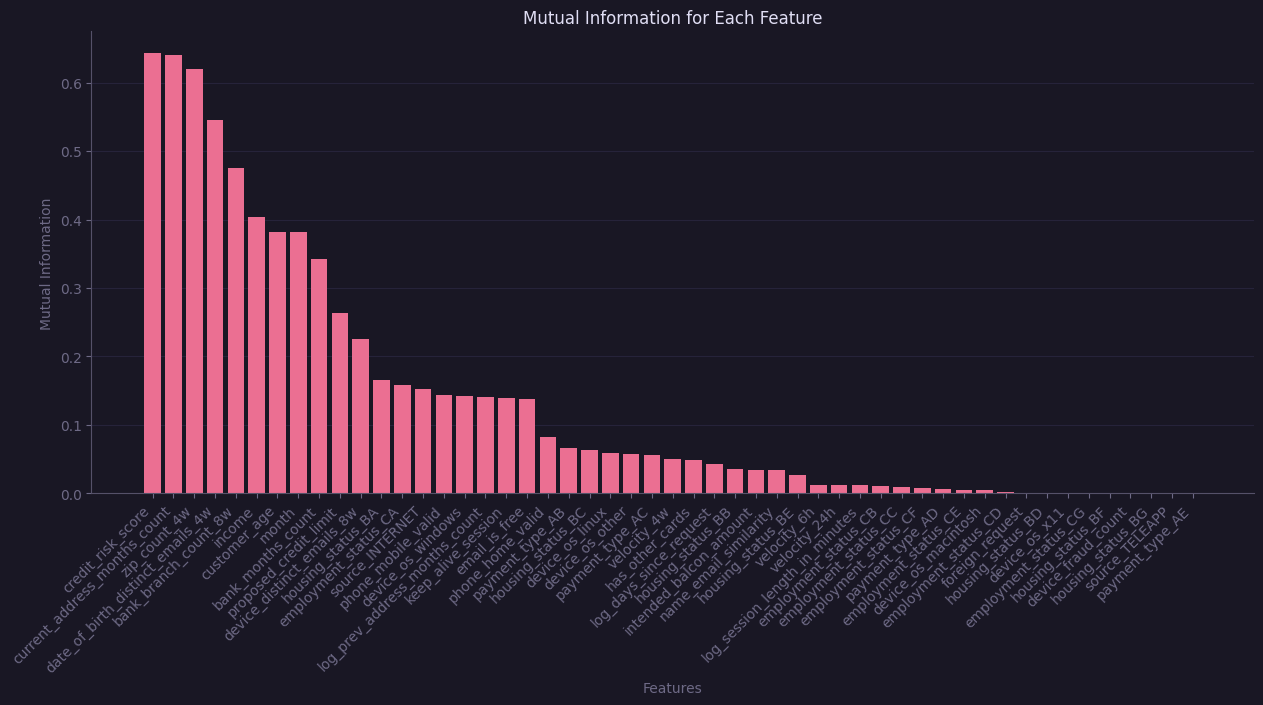

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the mutual_info_sort_pd DataFrame with columns 'feature' and 'mutual_info'
# mutual_info_sort_pd = pd.DataFrame({'feature': feature_names, 'mutual_info': mutual_info_sort})

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(range(len(mutual_info_sort_pd)), mutual_info_sort_pd['values'], align='center')
ax.set_xticks(range(len(mutual_info_sort_pd)))
ax.set_xticklabels(mutual_info_sort_pd['features'], rotation=45, ha='right')  # Use 'feature' column for xtick labels
ax.set_xlabel('Features')
ax.set_ylabel('Mutual Information')
ax.set_title('Mutual Information for Each Feature')
plt.show()


In [39]:
mutual_info_sort_pd[mutual_info_sort_pd['values']> 0.1]


,features,values
0,credit_risk_score,0.64
1,current_address_months_count,0.64
2,zip_count_4w,0.62
3,date_of_birth_distinct_emails_4w,0.55
4,bank_branch_count_8w,0.48
5,income,0.40
6,customer_age,0.38
7,month,0.38
8,bank_months_count,0.34
9,proposed_credit_limit,0.26


In [40]:
top_info_features = mutual_info_sort_pd[mutual_info_sort_pd['values'] > 0.1]['features']

#### Top Correlation Method - maybe remove. makes things confusing

Interesting to see that an alternative method of looking at highest correlation provides a vastly different list of features. Mutual information method will be used primarily and will compare the reuslts to correlation method as part of the analysis

In [41]:
corr = dataset_SMOTE.corr().round(2)

# Find features with strong correlation with target
target_corr = corr['fraud_bool'].abs().sort_values(ascending=False)
strong_corr_features = target_corr.index[1:11] 

print('Top 10 features with highest correlation with target:')
for feature in strong_corr_features:
    print(f"{feature}: {target_corr[feature]}")

Top 10 features with highest correlation with target:
housing_status_BA: 0.44
device_os_windows: 0.34
credit_risk_score: 0.32
customer_age: 0.29
proposed_credit_limit: 0.28
keep_alive_session: 0.27
income: 0.25
has_other_cards: 0.24
date_of_birth_distinct_emails_4w: 0.22
phone_home_valid: 0.22


----

# 6. Model Build

The aim is to assess a number of varying model and evaluate differences and performance.

Models:
- Linear Regression
- Random Forest
- Gradient Boosted ....GBA
- Artifical Neural Network (ANN)

- K Nearest Neighbour (KNN)

### 5.1 Data Preparation

Firstly need to split the data into testing and training data. Due to the large dataset a split of 80/20 has been taken.

In [42]:
# Split the data into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(dataset_SMOTE.drop('fraud_bool', axis=1),
                                                    dataset_SMOTE['fraud_bool'],
                                                    test_size=0.2,
                                                    random_state=0)

In [43]:
# Limiting the full dataset to just the feautures outlined
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = X_train[top_info_features]
X_test = X_test[top_info_features]


#### 5.1 Logistic Regression

What is Logistic regression?

In [44]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [45]:
lr.fit(X_train, y_train)

LogisticRegression()

In [46]:
lr_pred = lr.predict(X_test)

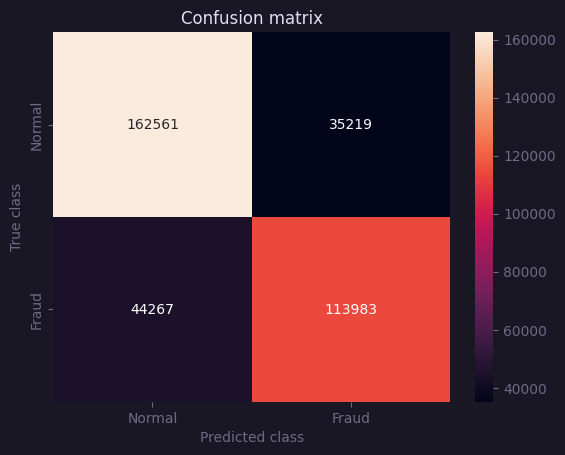

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, auc

LABELS = ['Normal', 'Fraud']

lr_matrix = confusion_matrix(y_test,lr_pred)
sns.heatmap(lr_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [48]:
accuracy_score(y_test,lr_pred)

0.7767435328483555

In [49]:
print (classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80    197780
           1       0.76      0.72      0.74    158250

    accuracy                           0.78    356030
   macro avg       0.77      0.77      0.77    356030
weighted avg       0.78      0.78      0.78    356030



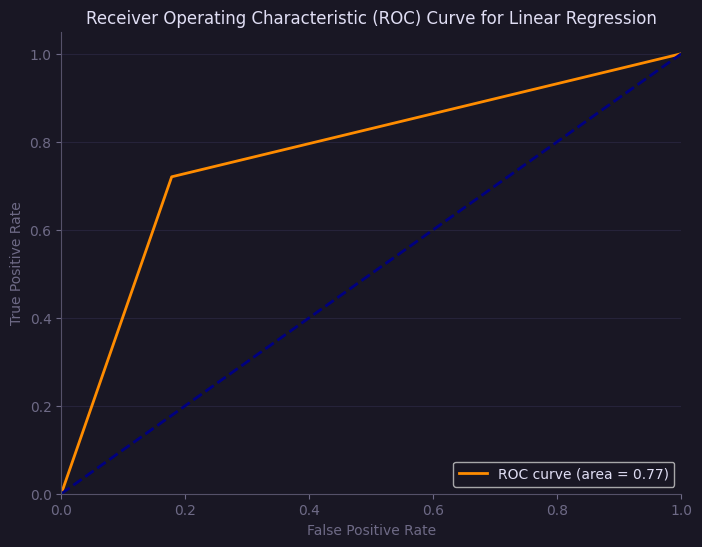

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, lr_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression')
plt.legend(loc='lower right')
plt.show()

## 5.2 Random Forest

How does random forest work?

In [51]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(max_samples=len(X_train),random_state=1)
rfc.fit(X_train,y_train)
# scores_pred = rfc.decision_function(X_train_smote_c)

RandomForestClassifier(max_samples=1424117, random_state=1)

In [52]:
rf_pred = rfc.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, auc, precision_score, recall_score, f1_score, matthews_corrcoef

import seaborn as sns

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    197780
           1       1.00      0.99      0.99    158250

    accuracy                           0.99    356030
   macro avg       0.99      0.99      0.99    356030
weighted avg       0.99      0.99      0.99    356030



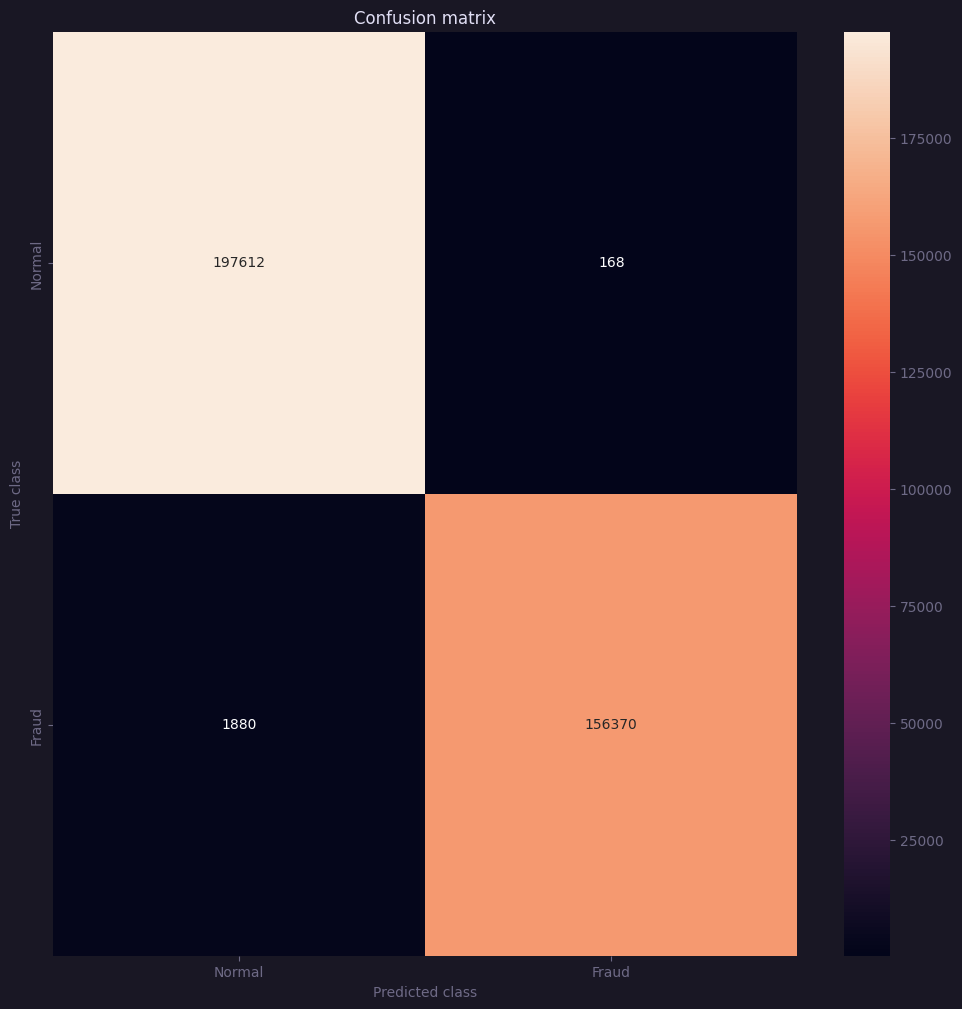

In [54]:
print(classification_report(y_test,rf_pred))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

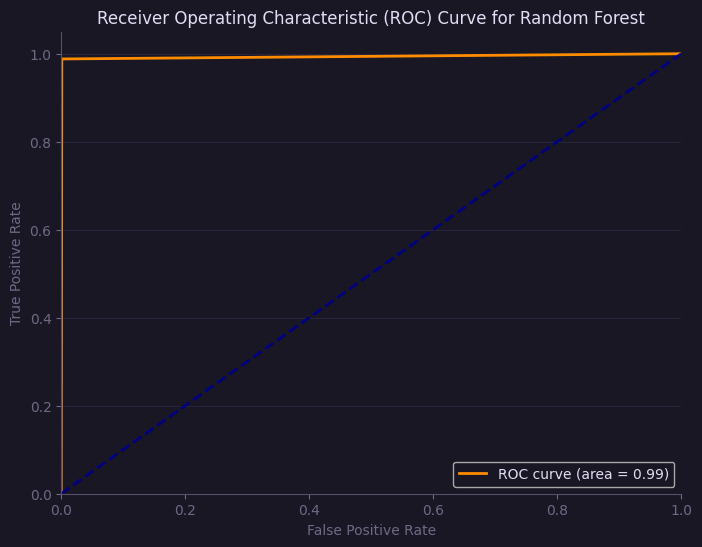

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

### 5.3 XGBoost Classification

In [56]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from xgboost import Booster
from xgboost import DMatrix

def xgboost_search(X, y, search_verbose=1):
    params = {
    "gamma":[0.5, 1, 1.5, 2, 5],
    "max_depth":[3,4,5,6],
    "min_child_weight": [100],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "learning_rate": [0.1, 0.01, 0.001]
    }
    xgb = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring="roc_auc", n_jobs=1, cv=skf.split(X,y), verbose=search_verbose)

    grid_search.fit(X, y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

In [57]:
import random
rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 50000)
model_params = xgboost_search(X_train.iloc[rows,], y_train.iloc[rows,])

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best estimator: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Parameters:  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 1.00


In [58]:
model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
model.set_params(**model_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Model outputs continous numbers, rather than just 1 or 0. This allows for a variable threshold to be used when classifying transactions. In practice, this could allow a user to set the threshold inline with their preference; such as accepting more false positives in the aim to identify more fraud correctly. To check this the threshold is varied and AUC is calculated for each step, the highest AUC is chosen in this instance.

Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

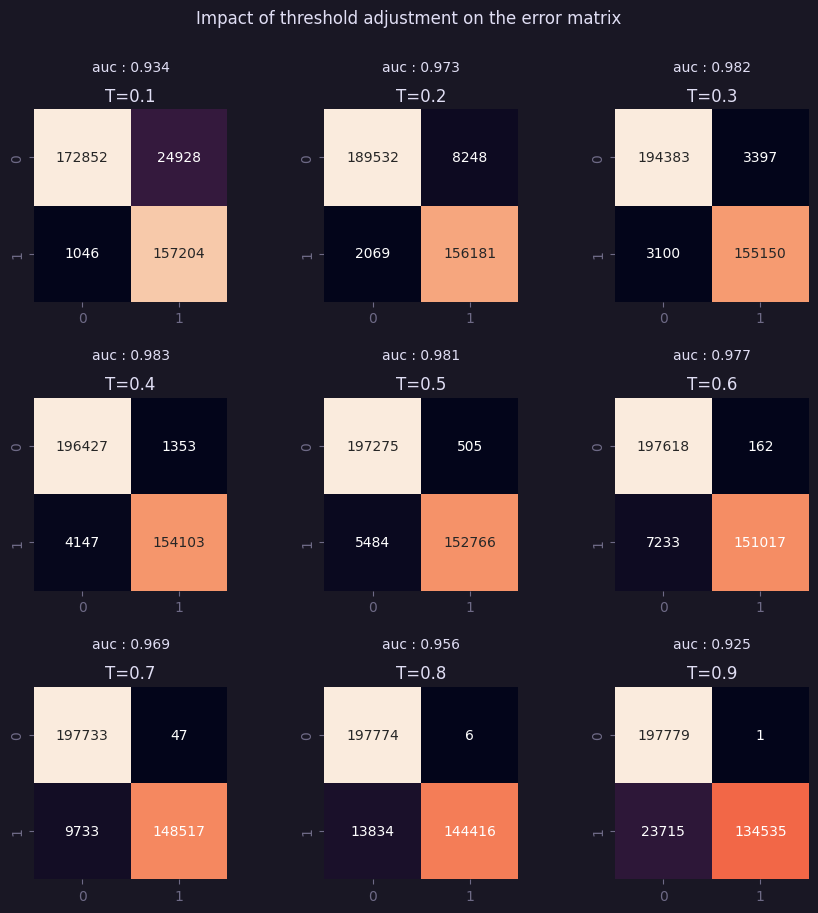

In [59]:
from sklearn import metrics
y_pred_XGB = model.predict_proba(X_test)[:,1]

fig, axes = plt.subplots(3,3, figsize=(10,10))

for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10

    y_pred_XGB_int = (y_pred_XGB > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_XGB_int)
    sns.heatmap(c_matrix, annot=True, fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_XGB_int)
    roc_auc = auc(fpr, tpr)
    ax.text(1.0, -0.4, "auc : {:.3f}".format(roc_auc), fontsize=10, ha='center')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

In [60]:
threshold = 0.4
y_pred_XGB_int = (y_pred_XGB > threshold).astype(int)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    197780
           1       0.99      0.97      0.98    158250

    accuracy                           0.98    356030
   macro avg       0.99      0.98      0.98    356030
weighted avg       0.98      0.98      0.98    356030



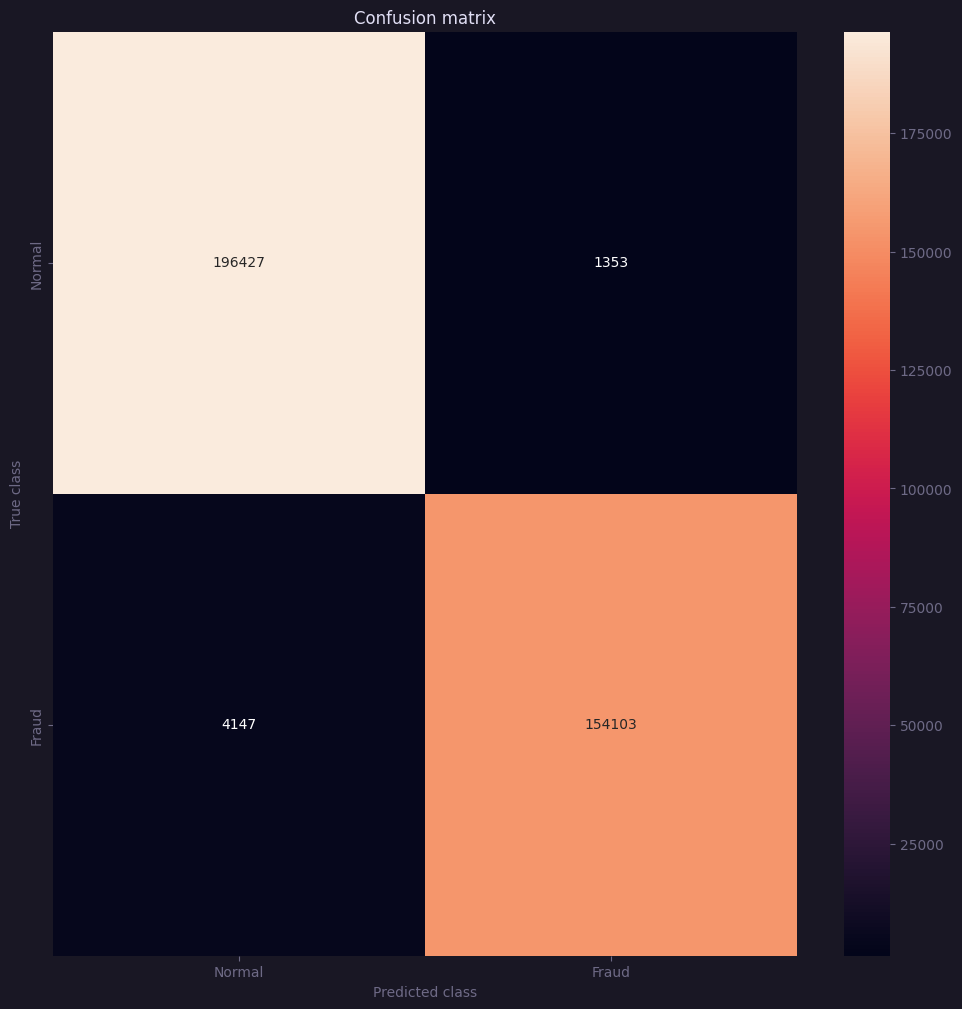

In [61]:
print(classification_report(y_test,y_pred_XGB_int))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred_XGB_int)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

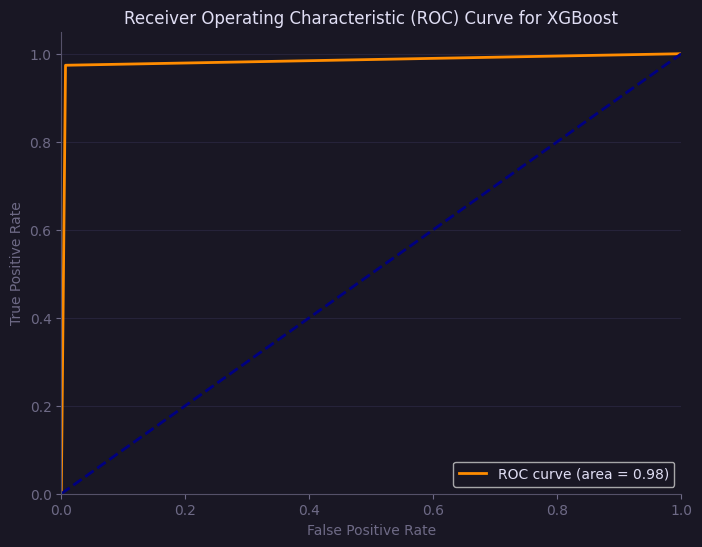

In [62]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_XGB_int)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

### 5.4 Artifical Neural Network

blah blah blah


In [69]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor


Epoch 1/10
44504/44504 [==============================] - 64s 1ms/step - loss: 0.4461 - accuracy: 0.7923
Epoch 2/10
44504/44504 [==============================] - 58s 1ms/step - loss: 0.4291 - accuracy: 0.8022
Epoch 3/10
17879/44504 [===========>..................] - ETA: 39s - loss: 0.4257 - accuracy: 0.8045

KeyboardInterrupt: 

In [137]:
from tensorflow import keras

model = []

model = keras.Sequential(
    [
        keras.layers.Dense(
            128, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_28"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 dense_113 (Dense)           (None, 128)               2560      
                                                                 
 dense_114 (Dense)           (None, 128)               16512     
                                                                 
 dropout_45 (Dropout)        (None, 128)               0         
                                                                 
 dense_115 (Dense)           (None, 256)               33024     
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_116 (Dense)           (None, 1)                 257       
                                                                 
Total params: 52353 (204.50 KB)
Trainable params: 52353 (204.50 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

In [138]:
metrics_ = [
    keras.metrics.AUC(name="AUC"),
    keras.metrics.Precision(name="precision")
    #keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics_,
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: 0, 1: 2}

model.fit(
    np.asarray(X_train).astype('float32'),
    np.asarray(y_train).astype('float32'),
    batch_size=5000,
    epochs=15,
    verbose=2,
    callbacks=callbacks,
    #validation_data=(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32')),
    #class_weight=class_weight,
)

Epoch 1/15
285/285 - 13s - loss: 0.4549 - AUC: 0.8657 - precision: 0.7629 - 13s/epoch - 44ms/step
Epoch 2/15
285/285 - 11s - loss: 0.4145 - AUC: 0.8903 - precision: 0.7860 - 11s/epoch - 39ms/step
Epoch 3/15
285/285 - 11s - loss: 0.3921 - AUC: 0.9023 - precision: 0.7986 - 11s/epoch - 37ms/step
Epoch 4/15
285/285 - 11s - loss: 0.3706 - AUC: 0.9127 - precision: 0.8104 - 11s/epoch - 39ms/step
Epoch 5/15
285/285 - 11s - loss: 0.3643 - AUC: 0.9157 - precision: 0.8128 - 11s/epoch - 38ms/step
Epoch 6/15
285/285 - 11s - loss: 0.3561 - AUC: 0.9195 - precision: 0.8164 - 11s/epoch - 37ms/step
Epoch 7/15
285/285 - 11s - loss: 0.3495 - AUC: 0.9226 - precision: 0.8197 - 11s/epoch - 39ms/step
Epoch 8/15
285/285 - 11s - loss: 0.3451 - AUC: 0.9245 - precision: 0.8196 - 11s/epoch - 38ms/step
Epoch 9/15
285/285 - 11s - loss: 0.3372 - AUC: 0.9281 - precision: 0.8254 - 11s/epoch - 37ms/step
Epoch 10/15
285/285 - 11s - loss: 0.3319 - AUC: 0.9305 - precision: 0.8278 - 11s/epoch - 38ms/step
Epoch 11/15
285/285

11126/11126 [==============================] - 11s 967us/step


Text(0.5, 0.98, 'Impact of threshold adjustment on the error matrix')

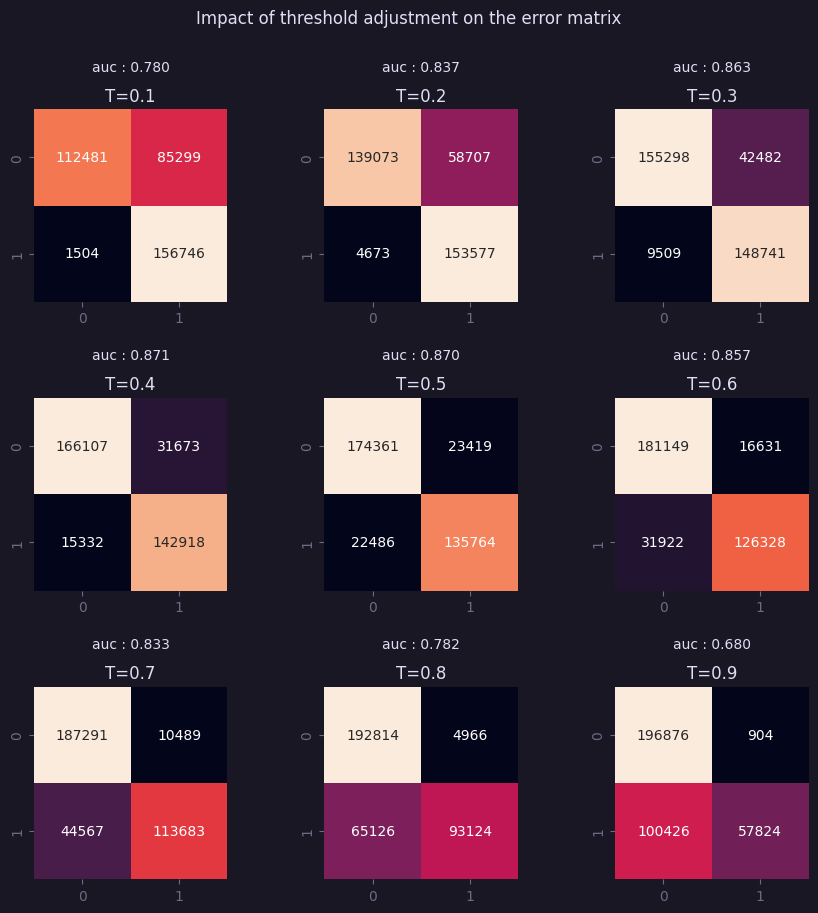

In [140]:
from sklearn import metrics
y_pred_ann = model.predict(np.asarray(X_test).astype('float32'))

fig, axes = plt.subplots(3,3, figsize=(10,10))

for t, ax in enumerate(axes.flat):
    threshold = (t+1)/10

    y_pred_ann_int = (y_pred_ann > threshold).astype(int)
    c_matrix = metrics.confusion_matrix(y_test, y_pred_ann_int)
    sns.heatmap(c_matrix, annot=True, fmt="d", ax=ax, cbar=False)
    ax.title.set_text("T=%.1f" % threshold)

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_ann_int)
    roc_auc = auc(fpr, tpr)
    ax.text(1.0, -0.4, "auc : {:.3f}".format(roc_auc), fontsize=10, ha='center')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Impact of threshold adjustment on the error matrix")

In [141]:
threshold = 0.5
y_pred_ann_int = (y_pred_ann > threshold).astype(int)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88    197780
           1       0.85      0.86      0.86    158250

    accuracy                           0.87    356030
   macro avg       0.87      0.87      0.87    356030
weighted avg       0.87      0.87      0.87    356030



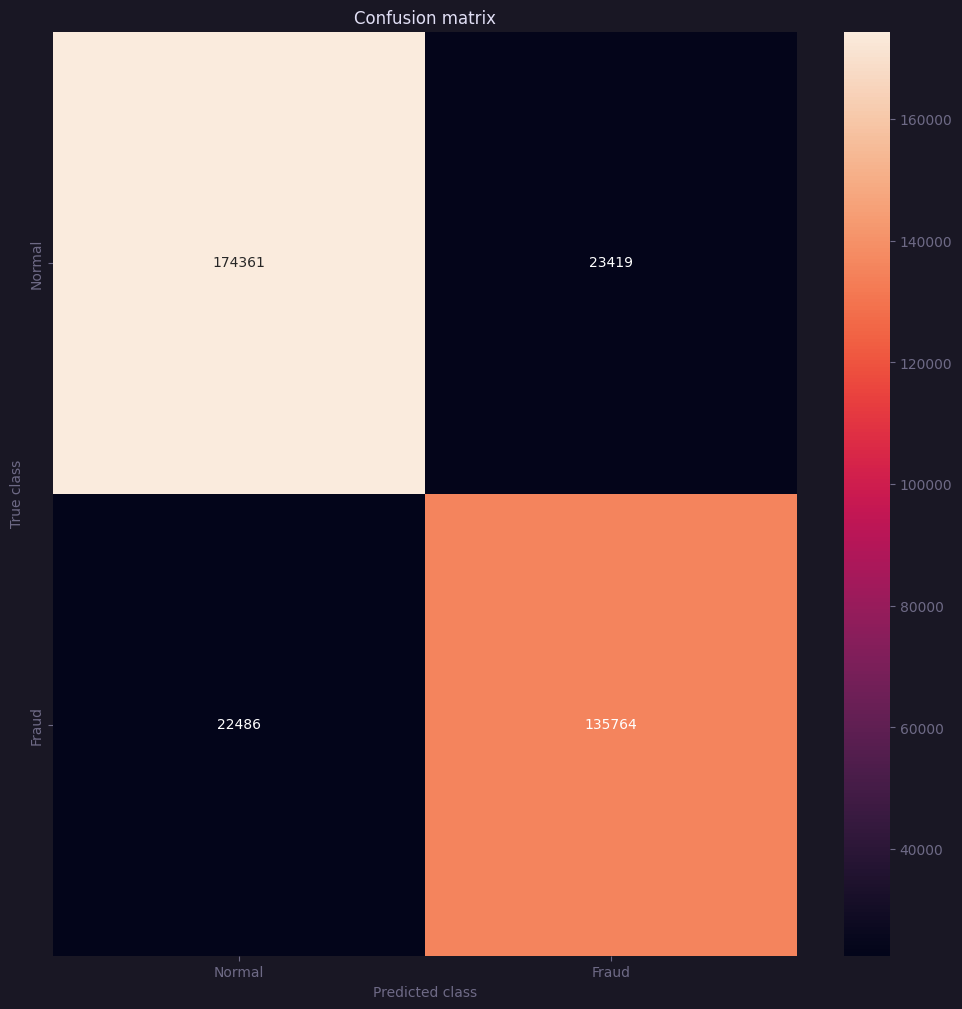

In [142]:
print(classification_report(y_test,y_pred_ann_int))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred_ann_int)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

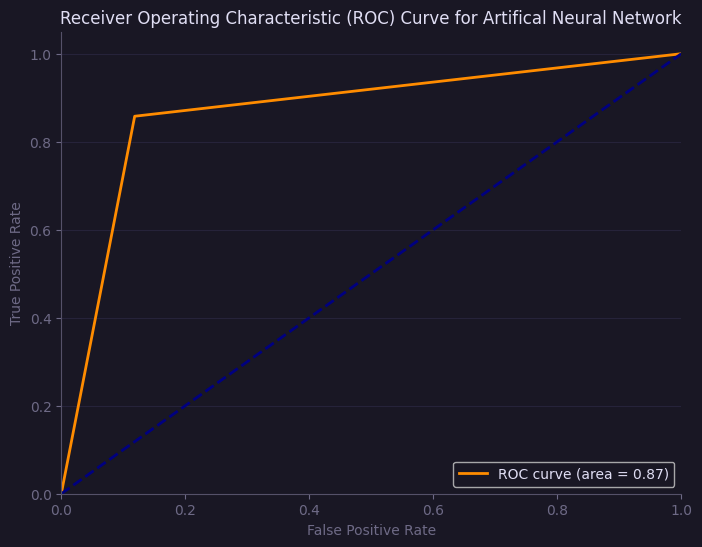

In [143]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ann_int)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Artifical Neural Network')
plt.legend(loc='lower right')
plt.show()

In [174]:
from keras.callbacks import EarlyStopping

In [180]:

from tensorflow import keras
from keras.callbacks import EarlyStopping

def build_model(hp):

    model = []

    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=64)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=64)

    model = keras.Sequential(
      [
          keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[-1],)),
          keras.layers.Dense(units = hp_units_1, activation="relu"),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(units = hp_units_2, activation="relu"),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(1, activation="sigmoid"),
      ]
    )

    metrics_ = [
    keras.metrics.AUC(name="AUC"),
    keras.metrics.Precision(name="precision")
    #keras.metrics.Recall(name="recall"),
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics_,
    )
           

    return model

In [181]:
import kerastuner as kt

tuner = kt.Hyperband(build_model,
                        objective= kt.Objective('AUC', direction='max'),
                        max_epochs = 5,
                        directory="MyDirectory",
                        project_name='Test__rw')

Reloading Tuner from MyDirectory\Test__rw\tuner0.json


In [182]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='AUC',  # Monitor auc for early stopping
    patience=3,  # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
) 

tuner.search(np.asarray(X_train).astype('float32'),
             np.asarray(y_train).astype('float32'),
             epochs=2,
             callbacks=[early_stopping],
             steps_per_epoch = 10000,
             validation_data=(np.asarray(X_test).astype('float32'),
                                np.asarray(y_test).astype('float32')))

tuner.get_best_hyperparameters()[0].values

Trial 21 Complete [00h 08m 30s]
AUC: 0.8700363636016846

Best AUC So Far: 0.8701342940330505
Total elapsed time: 23h 33m 40s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
160               |352               |units
224               |96                |units_1
96                |32                |units_2
10                |4                 |tuner/epochs
4                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |0                 |tuner/round
0015              |None              |tuner/trial_id

Epoch 5/10
 6094/44504 [===>..........................] - ETA: 1:46 - loss: 0.4628 - AUC: 0.8638 - precision: 0.7610

KeyboardInterrupt: 

--------------------------------

# GRAVE

In [223]:
X_train, X_test, y_train, y_test = train_test_split(cleaning_data.drop('fraud_bool', axis=1),
                                                    cleaning_data['fraud_bool'],
                                                    test_size=0.3,
                                                    random_state=0,
                                                    shuffle = True)

In [224]:
X_scaled = scaler.fit_transform(X_train)

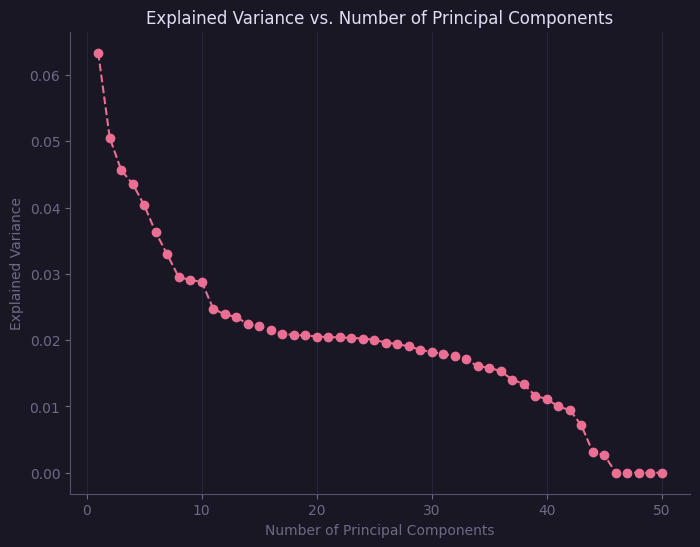

Cumulative Explained Variance:
PC1: 0.06
PC2: 0.11
PC3: 0.16
PC4: 0.20
PC5: 0.24
PC6: 0.28
PC7: 0.31
PC8: 0.34
PC9: 0.37
PC10: 0.40
PC11: 0.42
PC12: 0.45
PC13: 0.47
PC14: 0.49
PC15: 0.52
PC16: 0.54
PC17: 0.56
PC18: 0.58
PC19: 0.60
PC20: 0.62
PC21: 0.64
PC22: 0.66
PC23: 0.68
PC24: 0.70
PC25: 0.72
PC26: 0.74
PC27: 0.76
PC28: 0.78
PC29: 0.80
PC30: 0.82
PC31: 0.84
PC32: 0.85
PC33: 0.87
PC34: 0.89
PC35: 0.90
PC36: 0.92
PC37: 0.93
PC38: 0.94
PC39: 0.96
PC40: 0.97
PC41: 0.98
PC42: 0.99
PC43: 0.99
PC44: 1.00
PC45: 1.00
PC46: 1.00
PC47: 1.00
PC48: 1.00
PC49: 1.00
PC50: 1.00


In [226]:
from sklearn.decomposition import PCA

pca=PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(1, X_pca.shape[1] + 1)])

# Create a scree plot to visualize the explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

# Print the cumulative explained variance
print("Cumulative Explained Variance:")
for i, variance in enumerate(cumulative_variance, 1):
    print(f'PC{i}: {variance:.2f}')

In [235]:
# Define the number of principal components you want to keep
n_components = 20

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])

In [251]:
X_train, X_test, y_train, y_test = train_test_split(cleaning_data.drop('fraud_bool', axis=1),
                                                    cleaning_data['fraud_bool'],
                                                    test_size=0.2,
                                                    random_state=0,
                                                    shuffle = True)

In [252]:
# Apply SMOTE
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

Distribution of label values before applying SMOTE:
 fraud_bool
0    791142
1      8858
Name: count, dtype: int64
Distribution of label values after applying SMOTE:
 fraud_bool
0    791142
1    791142
Name: count, dtype: int64


In [570]:
# from imblearn.under_sampling import RandomUnderSampler
# undersampler = RandomUnderSampler(sampling_strategy=0.02, random_state=0)

# X_undersampled, y_understampled = undersampler.fit_resample(X_train, y_train)

# print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
# print('Distribution of label values after applying SMOTE:\n',pd.Series(y_understampled).value_counts())

In [571]:
# smote = SMOTE(sampling_strategy= 0.9,random_state=0)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print('Distribution of label values before applying SMOTE:\n',pd.Series(y_train).value_counts())
# print('Distribution of label values after applying SMOTE:\n',pd.Series(y_train_smote).value_counts())

In [253]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [258]:
# Define the number of principal components to retain
n_components = 10

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [270]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_pca, y_train_smote)

LogisticRegression()

In [271]:
y_pred = lr.predict(X_test_pca)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    197829
           1       0.06      0.54      0.10      2171

    accuracy                           0.89    200000
   macro avg       0.52      0.72      0.52    200000
weighted avg       0.98      0.89      0.93    200000



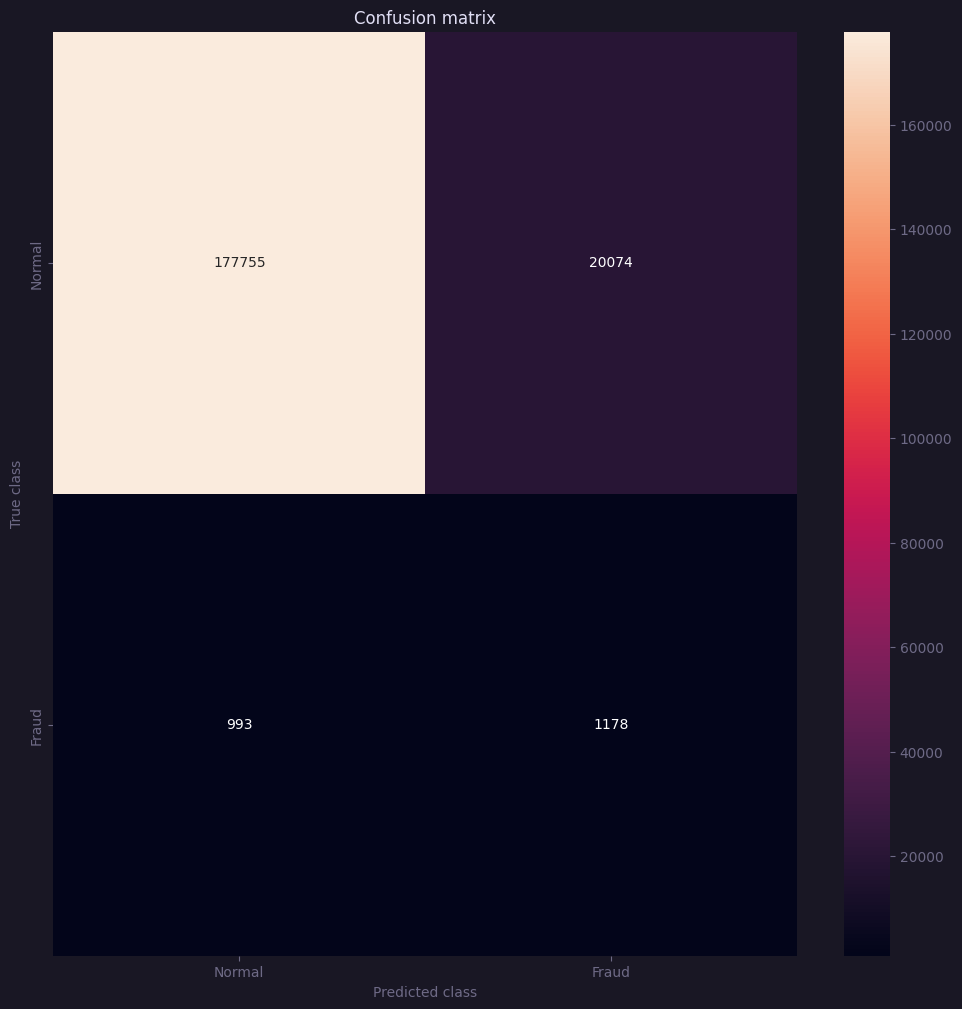

In [272]:
print(classification_report(y_test,y_pred))

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
            yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

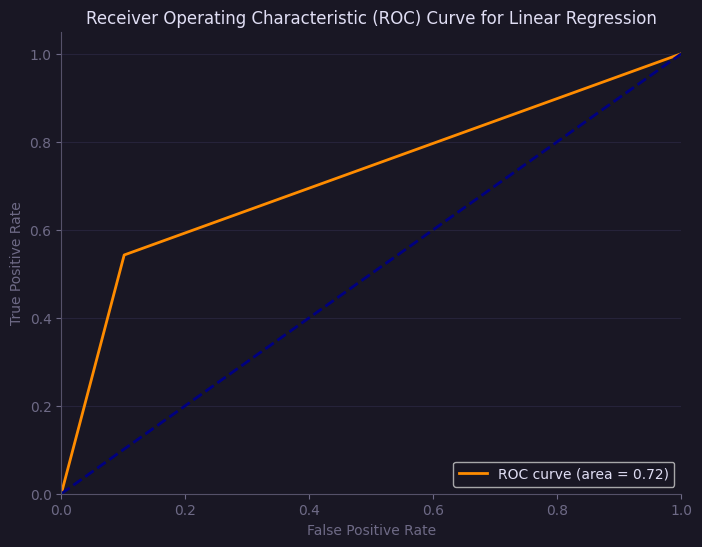

In [273]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear Regression')
plt.legend(loc='lower right')
plt.show()

Decision Tree method

In [665]:
# from sklearn.tree import DecisionTreeClassifier

# clf = DecisionTreeClassifier()
# clf.fit(kepler_X, kepler_y)

# pd.Series(clf.feature_importances_, index=kepler.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

In [666]:
# plt.style.use('rose-pine')

# # Create a bar chart
# plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
# bars = plt.bar(smote_counts['fraud_bool'],smote_counts['count'])
# plt.xlabel('Fraud Categories')
# plt.ylabel('Counts')
# plt.title('Fraud Counts by Category')

# labels = ['Ordinary', 'Fraudulent']

# # Add custom labels to the bars
# for bar, label in zip(bars, labels):
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.5, label, ha='center', color='white', fontsize=12)

# # Customize the x-axis tick labels
# plt.xticks([0, 1], ['0', '1'])

# # Show the chart
# plt.show()